In [1]:
## Importing libraries ##

# Data manipulation
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
## Scikit-learn packages ##

# Validation framework
from sklearn.model_selection import train_test_split
# Feature matrix formatter (dictionary vectoriser)
from sklearn.feature_extraction import DictVectorizer
# Logistic regression (sigmoid ver. linear regression)
from sklearn.linear_model import LogisticRegression

In [3]:
# Importing the data
df = pd.read_csv(r'..\Week 3\telco-customer-churn\WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Cleaning column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Storing categorical variables
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Cleaning contents of categorical series
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

# Parsing totalcharges as numeric (falsely parsed as an object)
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

# Converting yes/no to 1/0 (binary)
df.churn = (df.churn == 'yes').astype(int)

In [4]:
# Validation framework using sklearn
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

# Defining feature matrices
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Defining target-vector
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

# Removing target variable from feature matrices
del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
# Numerical series
numerical = ['tenure', 'monthlycharges', 'totalcharges']

# Categorical series
categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
# Initialising sklearn dictionary vectoriser (sparse matric == False)
dv = DictVectorizer(sparse=False)

# Converting train feature matrix to a dictionary, combining categorical and numerical series
train_dict = df_train[categorical + numerical].to_dict(orient='records')
# Transforming dictionary to formatted feature matrix using DictVectoriser
X_train = dv.fit_transform(train_dict)

# Initialising logistic regression model
model = LogisticRegression()
# Training model on train dataset
model.fit(X_train, y_train)

c:\Users\Tynan\anaconda3\envs\ml-zoomcamp-2023\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
# Converting validation feature matrix to a dictionary, combining categorical and numerical series
val_dict = df_val[categorical + numerical].to_dict(orient='records')
# Transforming dictionary to formatted feature matrix using DictVectoriser
X_val = dv.transform(val_dict)

# Obtaining predictions for validation set using predict_proba
y_pred = model.predict_proba(X_val)[:, 1]
# Classifying probability predictions into binary 
churn_decision = (y_pred >= 0.5)
# Evaluating binary predictions against actual outcomes (the target vector, y_val)
(y_val == churn_decision).mean()

0.8034066713981547

## Week 4

### Accuracy

Tells us the fraction of correct predictions.


1132 correct predictions out of 1409 predictions --> ~ 80% Accurate


We can modify the decision threshold and investigate whether the accuracy of our model improves or not.

0.5752575257525753 0.8062455642299503


Text(0, 0.5, 'Accuracy')

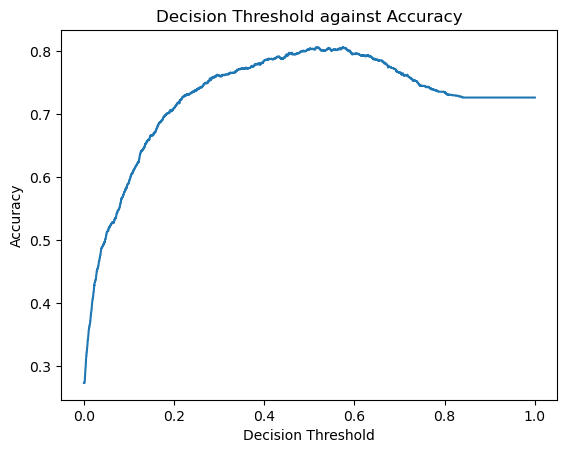

In [8]:
# Empty dictionary
threshold = {}

# Looping through array of linearly spaced numbers
for i in np.linspace(0,1, 10000):

    # Classifying probability predictions into binary 
    churn_decision = (y_pred >= i)
    
    # Saving accuracy of model and corresponding decision threshold
    threshold[i] = (y_val == churn_decision).mean()

# Printing results - Decision Threshold & Accuracy
print(max(threshold, key=threshold.get), threshold[max(threshold, key=threshold.get)])

# Creating tuples
x, y = zip(*threshold.items())

# Plotting results
plt.plot(x,y)
plt.title('Decision Threshold against Accuracy'); plt.xlabel('Decision Threshold'); plt.ylabel('Accuracy')

If we were to set the decision threshold to 1.0 then our model would give ~70% accuracy. This is simply the proportion of people not churning (as we are technically sending emails to nobody - estimating that no body will churn). Similarly, setting the decision threshold to 0.0 gives the proportion of people churning ~30%.

Why bother with a model then if we get 70% accuracy from not doing anything at all (dummy model)?

Well, because this dummy accuracy is a quirk of the current data (imbalances in class). Such would not necessaryily translate to the entire user base.

### Confusion Tables

A way of looking at errors and correct decisions that the binary classification model makes.

In [9]:
t = 0.5

actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [10]:
true_positive = (predict_positive & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()

false_positive = (predict_positive & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()

In [11]:
confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

Values in the leading diagonal represent incorrect predictions which results in the company losing some money:

- Not sending a promotional email when a user is likely to churn,
- Sending a promotional email despite a user not being likely to churn (uses discount)

In [12]:
# Percentage variant of confusion matrix
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

Main diagonal sums to our previously found accuracy value. Confusion matrices are descriptive of where exactly the model is accurate or not.

Confusion tables are also a prerequisite to ROC curves and precision/recall methods.

### Precision and Recall

Metrics used to evaluate binary classification models.

#### Precision

**Fraction of positive predictions which are correct**

In [13]:
precision = (true_positive) / (true_positive + false_positive)
precision

0.6752411575562701

Precision is ~67%. This tells us that ~33% of customers will receieve unnecessary promotional emails.

#### Recall

**Fraction of correctly identified positive examples (churning users)**

In [14]:
recall = (true_positive) / (true_positive + false_negative)
recall

0.5440414507772021

Recall at ~54% tells us that we failed to identify ~46% of churning users.

Accuracy is not the best metric to evaluate our model, as we have just seen. Having an accuracy of >=80% one might assume our model classifies users correctly most of the time, but this is not the case according to recall. In fact, we have barely managed to identify the majority of churning users. If we were to deploy this model going off of accuracy alone then we might be in some trouble because the full dataset may not have similar class proportions to our training data.

### ROC Curves

Receiver Operating Characteristics

To use, interesting in True Positive Rate (TPR) and False Positive Rate (FPR) - both computed using the confusion matrix.

False Positive Rate: Fraction of false positives amongst all negative examples - $\frac{\text{FP}}{\text{TN + FP}}$

True Positive Rate: Fraction of true positives amongst all positive examples - $\frac{\text{TP}}{\text{TP + FN}}$ - Same as **recall**

In [15]:
# Recall
tpr = true_positive / (true_positive + false_negative)
# FPR
fpr = false_positive / (false_positive + true_negative) 

print('For all positive values {}% are still predicted as being negative'.format(round((1 - tpr)*100,2)))
print('For all negative values {}% are still predicted as being positive'.format(round(fpr*100,2)))

For all positive values 45.6% are still predicted as being negative
For all negative values 9.87% are still predicted as being positive


In [16]:
scores = []

t = np.linspace(0, 1, 1001)

for i in t:

    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= i)
    predict_negative = (y_pred < i)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((i, tp, fp, fn, tn))


scores

[(0.0, 386, 1023, 0, 0),
 (0.001, 386, 1023, 0, 0),
 (0.002, 386, 1012, 0, 11),
 (0.003, 386, 996, 0, 27),
 (0.004, 386, 984, 0, 39),
 (0.005, 386, 964, 0, 59),
 (0.006, 386, 955, 0, 68),
 (0.007, 386, 945, 0, 78),
 (0.008, 386, 935, 0, 88),
 (0.009000000000000001, 386, 925, 0, 98),
 (0.01, 385, 914, 1, 109),
 (0.011, 385, 902, 1, 121),
 (0.012, 385, 897, 1, 126),
 (0.013000000000000001, 384, 890, 2, 133),
 (0.014, 384, 883, 2, 140),
 (0.015, 384, 871, 2, 152),
 (0.016, 384, 864, 2, 159),
 (0.017, 384, 856, 2, 167),
 (0.018000000000000002, 384, 844, 2, 179),
 (0.019, 384, 835, 2, 188),
 (0.02, 384, 830, 2, 193),
 (0.021, 384, 820, 2, 203),
 (0.022, 384, 812, 2, 211),
 (0.023, 383, 802, 3, 221),
 (0.024, 383, 795, 3, 228),
 (0.025, 383, 793, 3, 230),
 (0.026000000000000002, 383, 789, 3, 234),
 (0.027, 383, 783, 3, 240),
 (0.028, 383, 772, 3, 251),
 (0.029, 383, 768, 3, 255),
 (0.03, 383, 766, 3, 257),
 (0.031, 383, 762, 3, 261),
 (0.032, 383, 759, 3, 264),
 (0.033, 383, 750, 3, 273),
 (

In [17]:
df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.00,386,1023,0,0
10,0.01,385,914,1,109
20,0.02,384,830,2,193
30,0.03,383,766,3,257
40,0.04,381,715,5,308
...,...,...,...,...,...
960,0.96,0,0,386,1023
970,0.97,0,0,386,1023
980,0.98,0,0,386,1023
990,0.99,0,0,386,1023


In [18]:
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
10,0.01,385,914,1,109,0.997409,0.893451
20,0.02,384,830,2,193,0.994819,0.811339
30,0.03,383,766,3,257,0.992228,0.748778
40,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
960,0.96,0,0,386,1023,0.000000,0.000000
970,0.97,0,0,386,1023,0.000000,0.000000
980,0.98,0,0,386,1023,0.000000,0.000000
990,0.99,0,0,386,1023,0.000000,0.000000


Text(0.5, 1.0, 'Comparison of True and False Positive Rates')

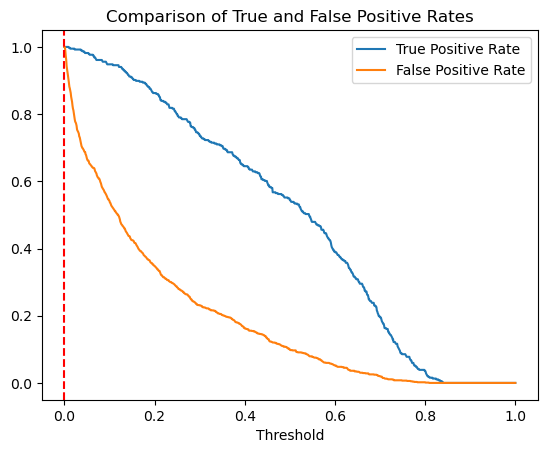

In [19]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='True Positive Rate')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='False Positive Rate')
plt.legend()
plt.axvline(x = 0, color='r', linestyle='--')
plt.xlabel('Threshold'); plt.title('Comparison of True and False Positive Rates')

Plot is good, but doesn't provide enough insights because we have nothing to compare it against. Hence, we want to consider the plots against a baseline (in our case, a random model)

### Random Model

In [20]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [21]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [22]:
def tpr_fpr_dataframe(y_val, y_pred):
    
    scores = []

    t = np.linspace(0, 1, 1001)

    for i in t:

        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= i)
        predict_negative = (y_pred < i)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((i, tp, fp, fn, tn))

    df_scores = pd.DataFrame(scores, columns=['threshold', 'tp', 'fp', 'fn', 'tn'])

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [23]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

Text(0.5, 1.0, 'Comparison of True and False Positive Rates')

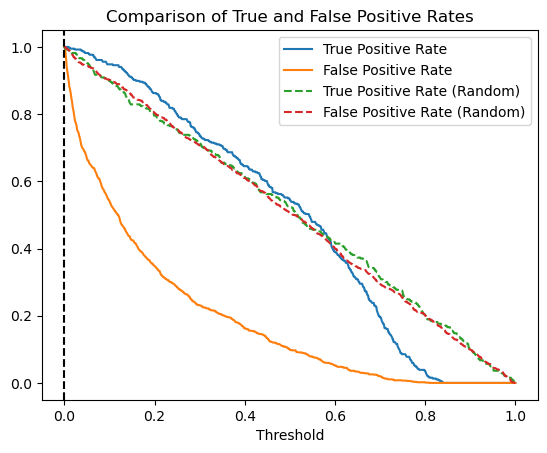

In [24]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='True Positive Rate')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='False Positive Rate')
plt.plot(df_rand['threshold'], df_rand['tpr'], label='True Positive Rate (Random)', linestyle='dashed')
plt.plot(df_rand['threshold'], df_rand['fpr'], label='False Positive Rate (Random)', linestyle='dashed')

plt.legend()
plt.axvline(x = 0, color='k', linestyle='--')
plt.xlabel('Threshold'); plt.title('Comparison of True and False Positive Rates')

### Ideal Model

In [25]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [26]:
# Repeats 0 num_neg times and then follows with num_pos 1s
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [28]:
((y_ideal_pred >= (1 - y_val.mean())) == y_ideal).mean()

1.0

In [29]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
10,0.01,386,1008,0,15,1.000000,0.985337
20,0.02,386,994,0,29,1.000000,0.971652
30,0.03,386,980,0,43,1.000000,0.957967
40,0.04,386,966,0,57,1.000000,0.944282
...,...,...,...,...,...,...,...
960,0.96,57,0,329,1023,0.147668,0.000000
970,0.97,43,0,343,1023,0.111399,0.000000
980,0.98,29,0,357,1023,0.075130,0.000000
990,0.99,15,0,371,1023,0.038860,0.000000


Text(0.5, 1.0, 'Comparison of True and False Positive Rates')

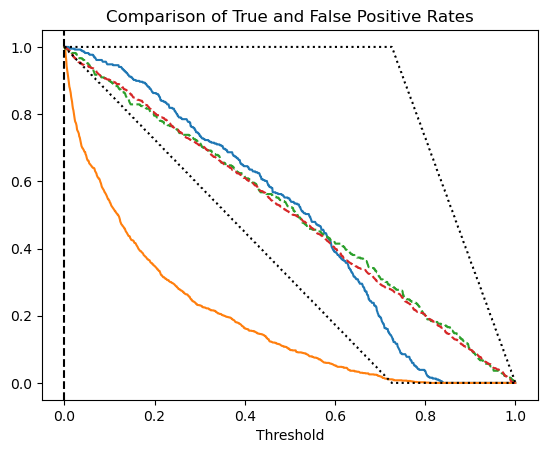

In [30]:
plt.plot(df_scores['threshold'], df_scores['tpr'], label='True Positive Rate')
plt.plot(df_scores['threshold'], df_scores['fpr'], label='False Positive Rate')

plt.plot(df_rand['threshold'], df_rand['tpr'], label='True Positive Rate (Random)', linestyle='dashed')
plt.plot(df_rand['threshold'], df_rand['fpr'], label='False Positive Rate (Random)', linestyle='dashed')

plt.plot(df_ideal['threshold'], df_ideal['tpr'], label='True Positive Rate (Ideal)', linestyle='dotted', color='k')
plt.plot(df_ideal['threshold'], df_ideal['fpr'], label='False Positive Rate (Ideal)', linestyle='dotted', color='k')

# plt.legend()
plt.axvline(x = 0, color='k', linestyle='--')
plt.xlabel('Threshold'); plt.title('Comparison of True and False Positive Rates')

#### Comparison of true and false positive rates

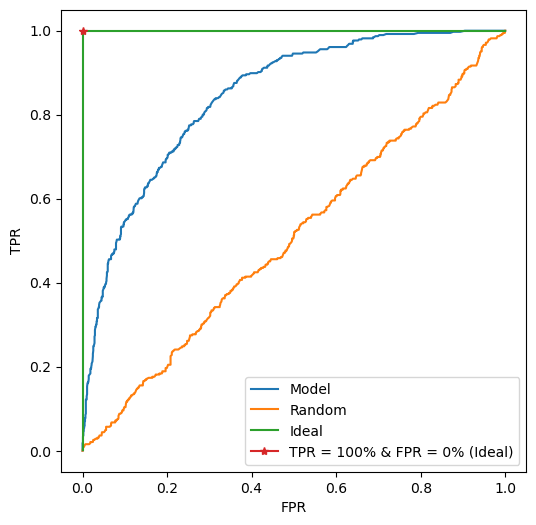

In [31]:
plt.figure(figsize=(6,6))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='Ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot([1], marker='*', label='TPR = 100% & FPR = 0% (Ideal)')

plt.legend()

ROC curves can also be plot using scikit-learn

In [32]:
from sklearn.metrics import roc_curve

In [33]:
fpr, tpr, t = roc_curve(y_val, y_pred)

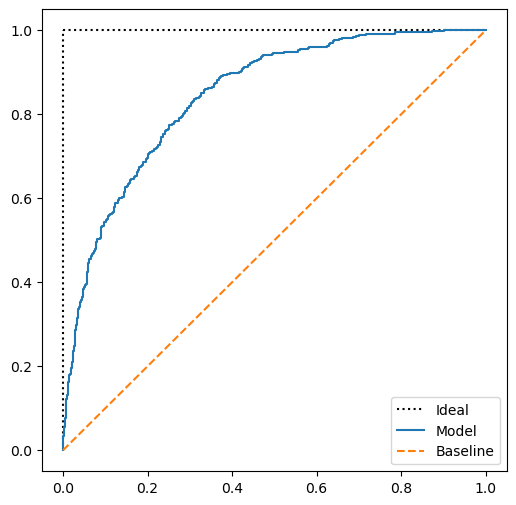

In [34]:
plt.figure(figsize=(6,6))

plt.plot([0,1], [1,1], color='k', linestyle='dotted', label='Ideal')
plt.plot([0,0], [0,1], color='k', linestyle='dotted')
plt.plot(fpr,tpr, label='Model')
plt.plot([0,1], linestyle='dashed', label='Baseline')

plt.legend(loc=4)

### ROC AUC (Area Under Curve)

AUC = Quantification of distance from ideal curve

$0.5 \leq \textbf{AUC} \leq 1$ 

In [35]:
from sklearn.metrics import auc

In [36]:
auc(fpr, tpr)

0.8438251814484473

In [37]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred)

0.8438251814484473